## Todos

- calculate centrality measure only once
- replace randomize_graph in basic_graph_analyzer.py by utils function

In [1]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer


In [2]:
from graph_tool import openmp_set_num_threads

# Set the number of threads to use
openmp_set_num_threads(8)

In [3]:
from graph_tool.all import load_graph

file_path = 'outputs/graphs/Amiga_CD32_games.gt'

G = load_graph(file_path)

num_nodes = G.num_vertices()
num_edges = G.num_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 8013
Number of edges: 1537410


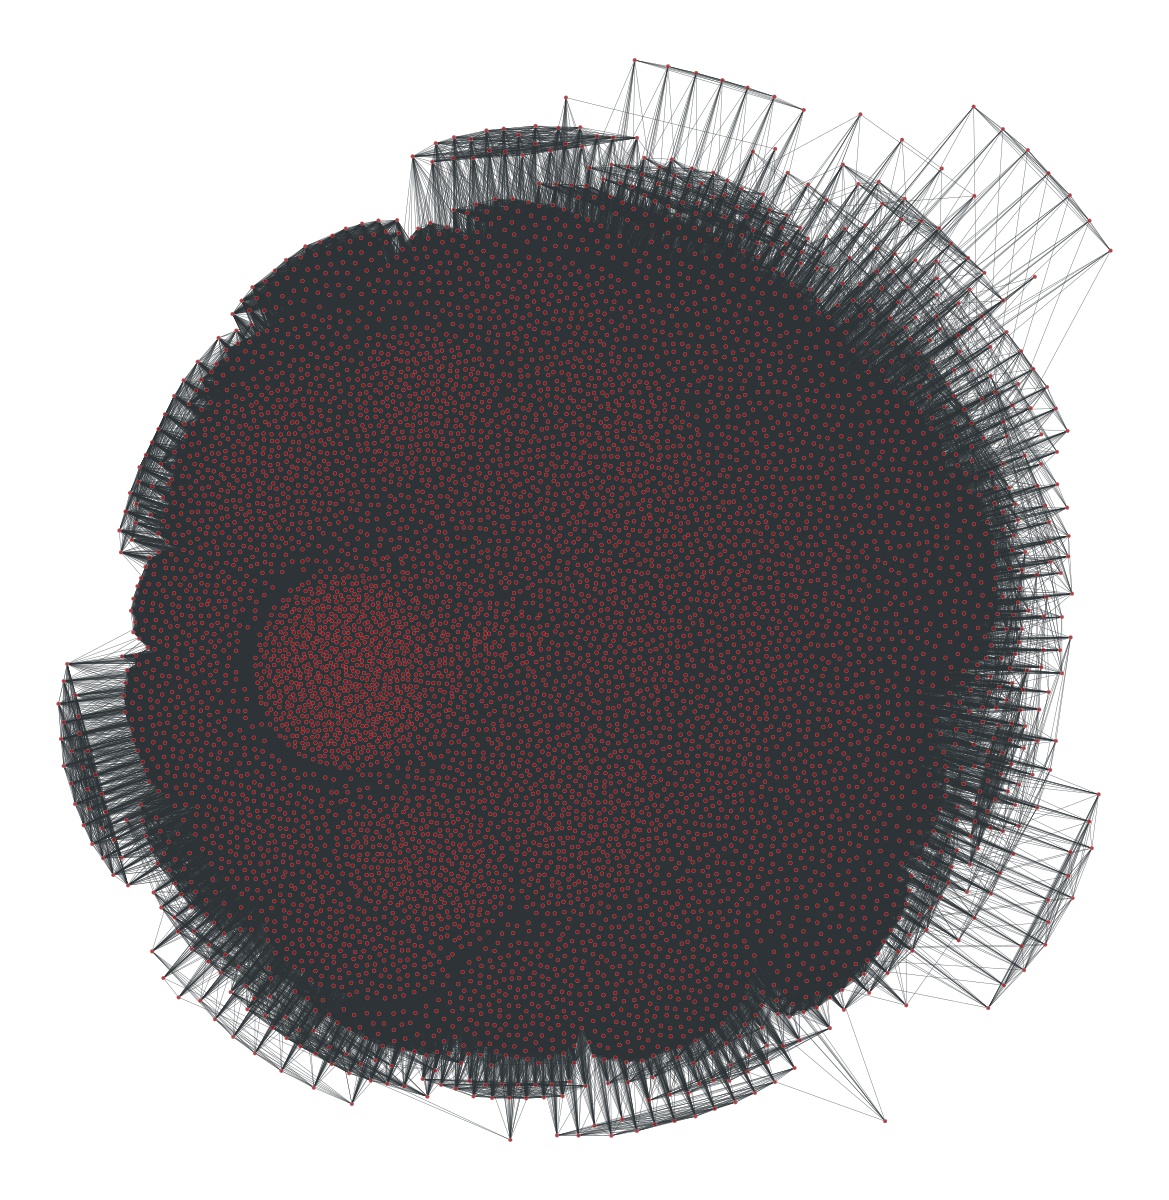

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16a1f5300, at 0x179e31a20>

In [12]:
from graph_tool.draw import sfdp_layout
from graph_tool.draw import graph_draw

pos = sfdp_layout(G)
graph_draw(G, pos)


In [ ]:
basic_graph_analyzer = BasicGraphAnalyzer(G)
basic_graph_analyzer.plot_degree_vs_avg_degree("Degree vs Average Degree of Neighbors", plot_randomized=True)
basic_graph_analyzer.plot_log_log_probability_density('Amiga CD32 games')

Processing vertices:  15%|█▍        | 1182/8013 [00:02<00:11, 603.49vertex/s]

Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.05 seconds.

Calculating closeness...
Closeness centrality calculated in 12.35 seconds.

Calculating betweenness...
Betweenness centrality calculated in 18.05 seconds.



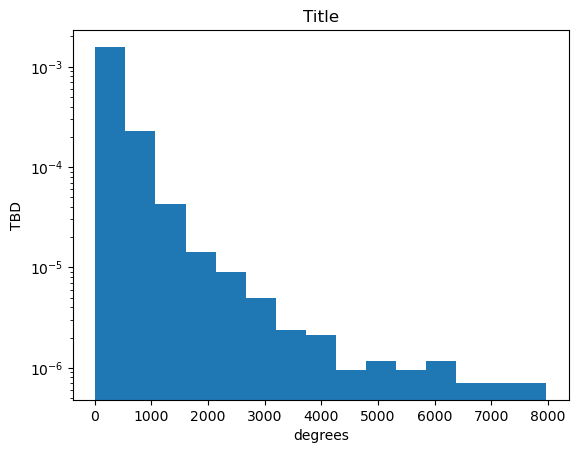

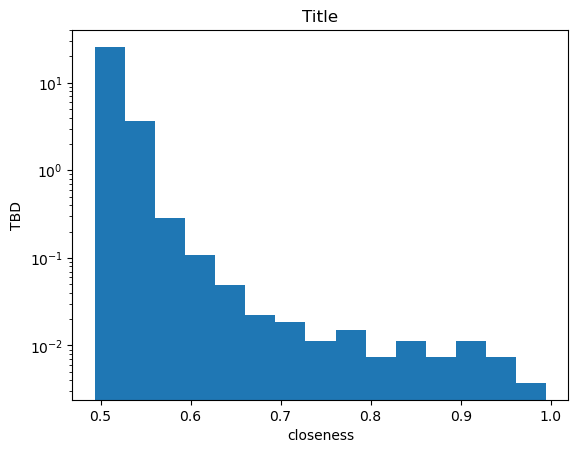

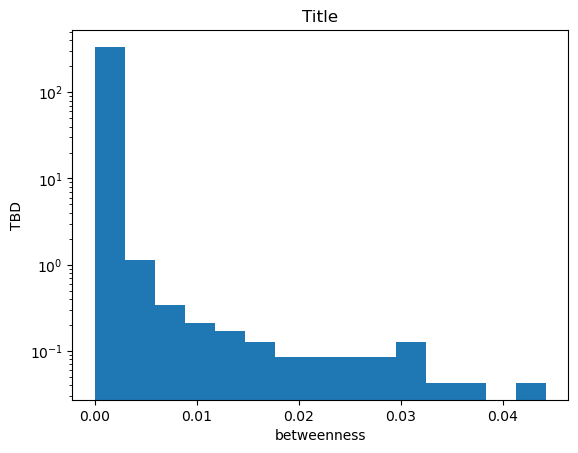

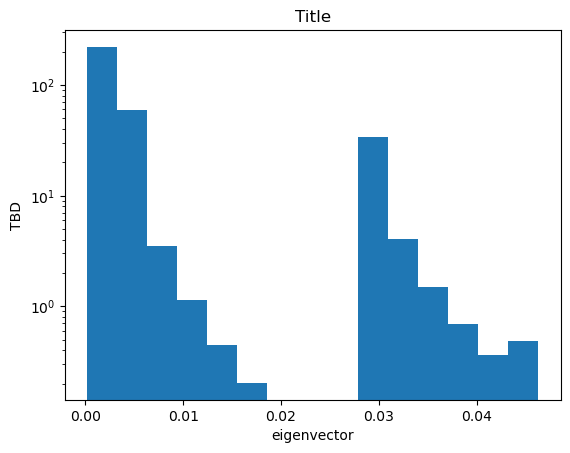

Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.04 seconds.

Calculating closeness...
Closeness centrality calculated in 13.95 seconds.

Calculating betweenness...
Betweenness centrality calculated in 18.35 seconds.



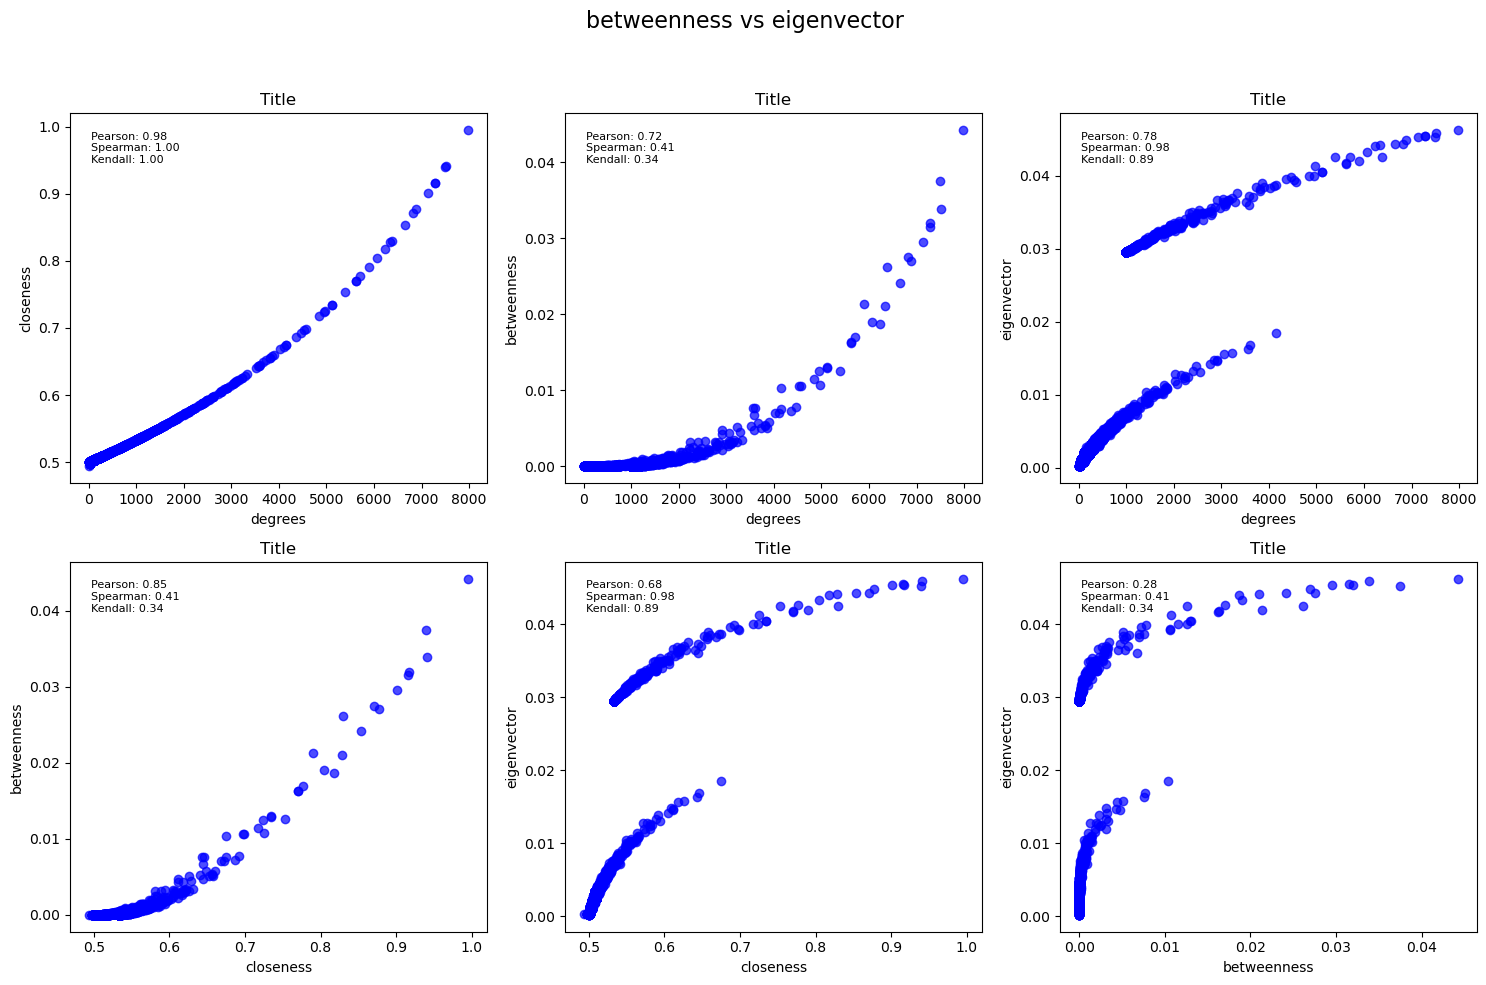

Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.06 seconds.

Calculating closeness...
Closeness centrality calculated in 14.44 seconds.

Calculating betweenness...
Betweenness centrality calculated in 20.63 seconds.

Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.02 seconds.

Calculating closeness...
Closeness centrality calculated in 15.41 seconds.

Calculating betweenness...
Betweenness centrality calculated in 29.08 seconds.



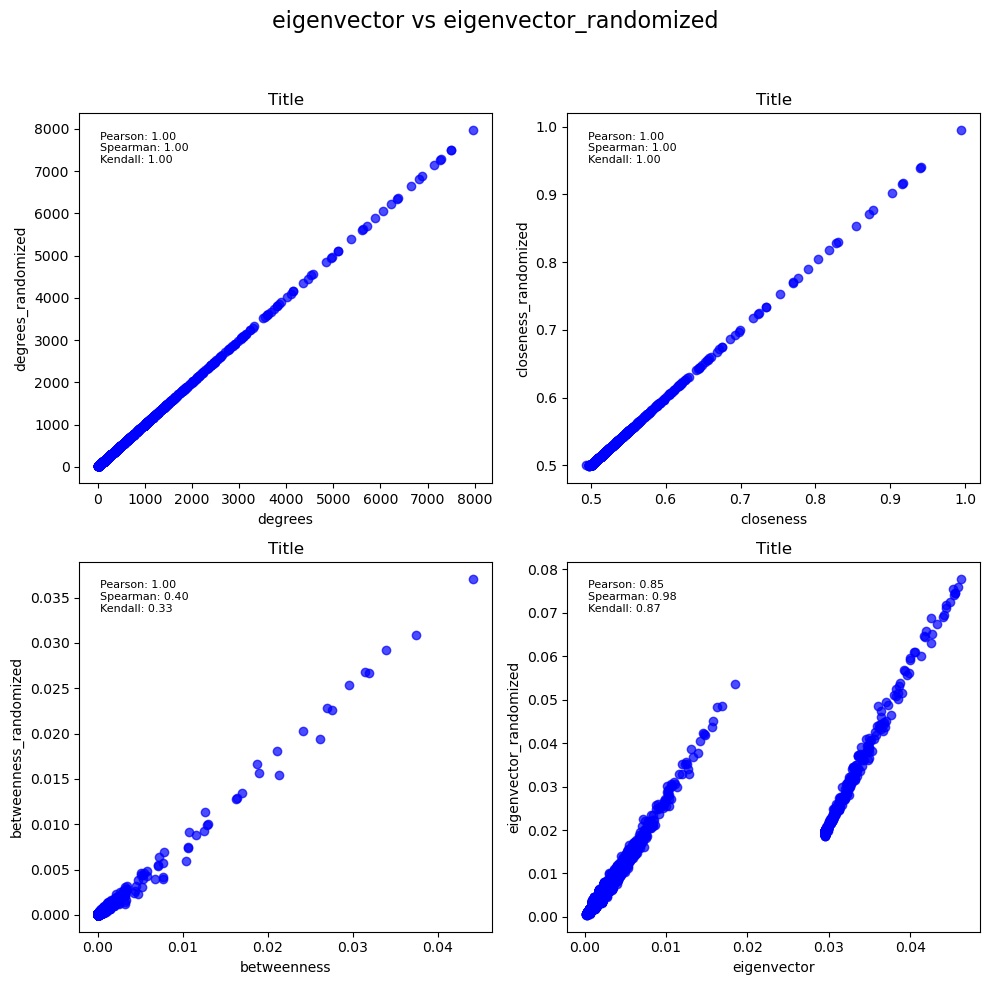

In [5]:
centrality_analyzer = CentralityAnalyzer(G)
centrality_analyzer.plot_centralities()
centrality_analyzer.plot_centralities_comparison()
centrality_analyzer.plot_centralities_comparison_randomized()

In [87]:
import graph_tool.all as gt

file_path = 'data/processed/graph_internet.gml'
g = load_graph(file_path)

file_path = 'outputs/graphs/Amiga_CD32_games.gt'
# file_path = 'data/processed/graph_jazz_collab.gml'

G_prime = load_graph(file_path)

file_path = 'outputs/graphs/Amiga_CD32_games-weighted.gt'
# file_path = 'data/processed/graph_jazz_collab.gml'

G_weighted = load_graph(file_path)

In [75]:
from scipy import special

def calculate_poisson_degree_distribution(degrees, logarithmic_bins):
    lamda = np.mean(degrees)
    x = logarithmic_bins
    y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
    x = x[y > 0]
    y = y[y > 0]
    return x, y

def calculate_exponential_degree_distribution(degrees, logarithmic_bins):
    lamda = np.mean(degrees)
    beta = 1 / lamda
    x = logarithmic_bins
    y = beta * np.exp(-beta * x)
    # remove entries with 0 probability
    x = x[y > 0]
    y = y[y > 0]
    return x, y

In [76]:
# !pip install powerlaw
import powerlaw

def get_degrees(G, weighted=False):
    if weighted:
        weights = G.edge_properties["weight"]
        return [sum(weights[e] for e in v.out_edges()) for v in G.vertices()]
    else:
        return G.get_out_degrees(G.get_vertices())

def fit_power_law(degrees):
    fit = powerlaw.Fit(degrees)
    return fit.power_law.alpha, fit.power_law.sigma

In [90]:
print(50*'-')
degrees = get_degrees(G_weighted, weighted=True)
alpha, sigma = fit_power_law(degrees)
print()
print()
print(f'Exponent: {alpha}')
print(f'Error: {sigma}')


print(50*'-')
degrees = get_degrees(G_prime)
alpha, sigma = fit_power_law(degrees)
print()
print()
print(f'Exponent: {alpha}')
print(f'Error: {sigma}')

print(50*'-')
degrees = get_degrees(g)
alpha, sigma = fit_power_law(degrees)
print()
print()
print(f'Exponent: {alpha}')
print(f'Error: {sigma}')

--------------------------------------------------
Calculating best minimal value for power law fit
xmin progress: 99%

Exponent: 2.2510398628113677
Error: 0.07544054223132728
--------------------------------------------------
Calculating best minimal value for power law fit
xmin progress: 99%

Exponent: 2.8600320045364143
Error: 0.0957965220056621
--------------------------------------------------
Calculating best minimal value for power law fit
xmin progress: 99%

Exponent: 2.112191339113011
Error: 0.0366878070312722


In [78]:

# define a function to plot the degree distribution
def plot_degree_distribution(graph, title, weighted=False):
    degrees = get_degrees(graph, weighted)
    title = f"Graph: {title}"
    print(f"{20*'-'} {title} {20*'-'}")
    # print(f"Number of Nodes: {len(graph['graph'])}")
    print(f"Graph average degree: {np.mean(degrees)}")
    print(f"Graph max degree: {max(degrees)}")
    print(f"Graph min degree: {min(degrees)}")
    print((42 + len(title))*'-')

    logarithmic_bins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), num=20)

    # plot histogram as line and dots
    hist_densitiy, bin_edges = np.histogram(degrees, bins=logarithmic_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Find the center of each bin
    #remove values with 0 probability
    bin_centers = bin_centers[hist_densitiy > 0]
    hist_densitiy = hist_densitiy[hist_densitiy > 0]
    plt.plot(bin_centers, hist_densitiy, '-o', label='Degree', alpha=0.8)

    x,y = calculate_poisson_degree_distribution(degrees, logarithmic_bins)
    plt.plot(x, y, color='g', linestyle='-', label='Poisson Distribution')

    x,y = calculate_exponential_degree_distribution(degrees, logarithmic_bins)
    plt.plot(x, y, color='b', linestyle='-', label='Exponential Distribution')

    # add the power law fit to the plot
    fit = powerlaw.Fit(degrees, discrete=True, xmin=1)
    fit.power_law.plot_pdf(color='r', linestyle='--', label='Power Law Fit')

    plt.xscale('log')  # This was missing in original
    plt.yscale('log')
    plt.ylim([0.001*min(hist_densitiy), 100*max(hist_densitiy)])
    plt.legend()
    plt.title(f'Degree Distribution {title}')
    plt.xlabel('Degree')
    plt.ylabel('Probability Density')
    plt.show()
    



-------------------- Graph: weighted Amiga CD32 games --------------------
Graph average degree: 1292.9362286284788
Graph max degree: 381435
Graph min degree: 14
--------------------------------------------------------------------------


/var/folders/6n/z07t7gbd3rv1k716vnnpf4n00000gn/T/ipykernel_25629/3507845554.py:6: RuntimeWarning: overflow encountered in power
  y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
/var/folders/6n/z07t7gbd3rv1k716vnnpf4n00000gn/T/ipykernel_25629/3507845554.py:6: RuntimeWarning: invalid value encountered in multiply
  y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)


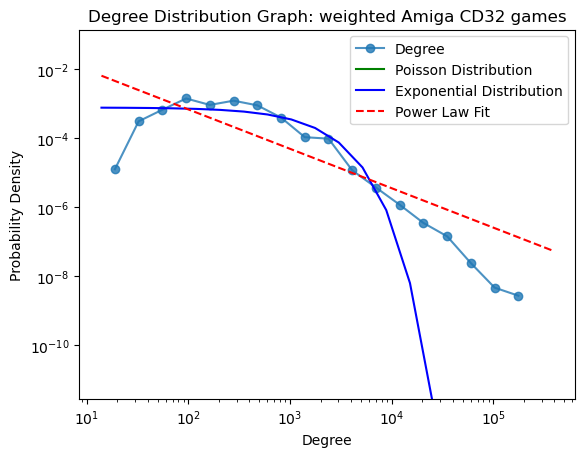

-------------------- Graph: Amiga CD32 games --------------------
Graph average degree: 383.72894047173344
Graph max degree: 7969
Graph min degree: 10
-----------------------------------------------------------------


/var/folders/6n/z07t7gbd3rv1k716vnnpf4n00000gn/T/ipykernel_25629/3507845554.py:6: RuntimeWarning: invalid value encountered in divide
  y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)


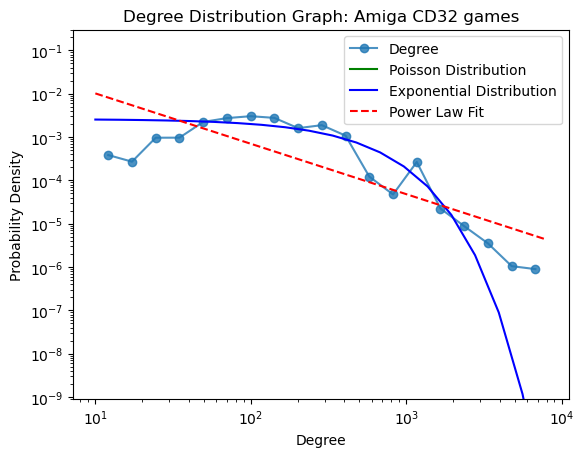

-------------------- Graph: Internet --------------------
Graph average degree: 6.197750352406432
Graph max degree: 2760
Graph min degree: 1
---------------------------------------------------------


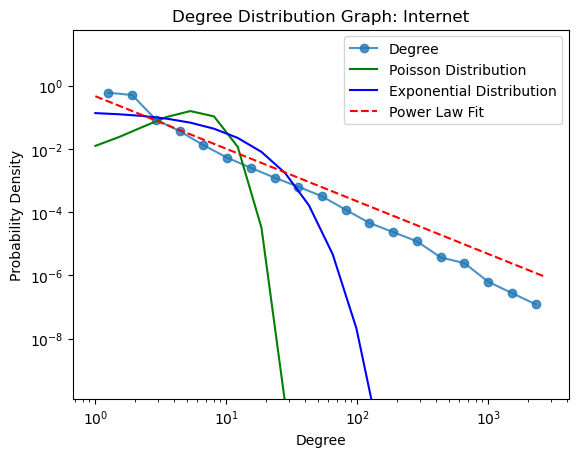

In [92]:
plot_degree_distribution(G_weighted, 'weighted Amiga CD32 games', weighted=True)

plot_degree_distribution(G_prime, 'Amiga CD32 games', weighted=False)

plot_degree_distribution(g, 'Internet', weighted=False)


